<a href="https://colab.research.google.com/github/yuktachikate/FinGuard-GPU-Accelerated-Financial-Fraud-Detection/blob/main/FinGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Check for GPU availability in Colab (should be enabled for GPU acceleration)
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU found: {device_name}")
else:
    print("No GPU found. Please enable GPU runtime in Colab.")

No GPU found. Please enable GPU runtime in Colab.


This cell imports the essential libraries. We use TensorFlow/Keras for the deep learning model, scikit-learn for preprocessing and evaluation, and Matplotlib for visualization. It also checks for a GPU to ensure that our training is accelerated.

In [34]:
# Data Acquisition & Loading
# ===============================
# For this example, we use the Credit Card Fraud Detection dataset.
# Download the dataset from:
# https://www.kaggle.com/mlg-ulb/creditcardfraud
# After downloading, upload the CSV file into your Google Colab session.

from google.colab import files
uploaded = files.upload()  # Upload the 'creditcard.csv' file when prompted.

# Load the dataset into a pandas DataFrame
df = pd.read_csv('creditcard1.csv')
print("Dataset shape:", df.shape)
df.head()

Saving creditcard1.csv to creditcard1 (5).csv
Dataset shape: (999, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In this cell, you upload the dataset (creditcard.csv). This dataset contains transactions labeled as fraudulent or legitimate. Once uploaded, the file is read into a DataFrame and a preview is displayed.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    999 non-null    int64  
 1   V1      999 non-null    float64
 2   V2      999 non-null    float64
 3   V3      999 non-null    float64
 4   V4      999 non-null    float64
 5   V5      999 non-null    float64
 6   V6      999 non-null    float64
 7   V7      999 non-null    float64
 8   V8      999 non-null    float64
 9   V9      999 non-null    float64
 10  V10     999 non-null    float64
 11  V11     999 non-null    float64
 12  V12     999 non-null    float64
 13  V13     999 non-null    float64
 14  V14     999 non-null    float64
 15  V15     999 non-null    float64
 16  V16     999 non-null    float64
 17  V17     999 non-null    float64
 18  V18     999 non-null    float64
 19  V19     999 non-null    float64
 20  V20     999 non-null    float64
 21  V21     999 non-null    float64
 22  V2

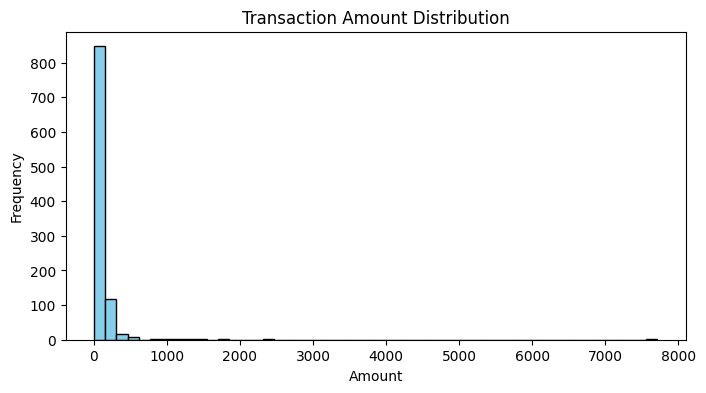

In [35]:

# Exploratory Data Analysis (EDA)
# ===============================
print(df.info())
print(df.describe())

# Check class imbalance
print("Class distribution:")
print(df['Class'].value_counts())

# Plotting the distribution of the 'Amount' feature
plt.figure(figsize=(8,4))
plt.hist(df['Amount'], bins=50, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


This cell performs basic EDA. We inspect data types, summary statistics, and look at the distribution of the 'Amount' feature. The imbalance in classes (fraud vs. non-fraud) is crucial since fraud cases are very rare.

In [36]:
# Data Preprocessing
# ===============================
# Separate features and target
X = df.drop(['Class', 'Time'], axis=1)  # Dropping 'Time' since it may not be relevant
y = df['Class']

# Standardize features (except for 'Amount', which we include here for simplicity)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset (stratify to maintain class imbalance in both sets)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (799, 29)
Test set shape: (200, 29)


We preprocess the data by standardizing features and splitting into training and test sets. Stratified splitting ensures that both sets maintain the same proportion of fraud cases as in the full dataset.

In [9]:
# Building the Deep Neural Network Model
# ===============================
# Construct a sequential neural network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,633 (6.38 KB)

 Trainable params: 1,633 (6.38 KB)

 Non-trainable params: 0 (0.00 B)

Here we define a deep neural network with multiple dense layers and dropout to prevent overfitting. The final layer uses a sigmoid function because we are performing binary classification (fraud vs. non-fraud).

In [10]:
# Training the Model
# ===============================
# Use early stopping to halt training when validation performance stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
1/1 - 6s - 6s/step - accuracy: 0.1205 - loss: 1.1648 - val_accuracy: 0.1000 - val_loss: 1.0784
Epoch 2/50
1/1 - 1s - 1s/step - accuracy: 0.1393 - loss: 1.0881 - val_accuracy: 0.1312 - val_loss: 1.0499
Epoch 3/50
1/1 - 0s - 368ms/step - accuracy: 0.1487 - loss: 1.0680 - val_accuracy: 0.1437 - val_loss: 1.0222
Epoch 4/50
1/1 - 1s - 563ms/step - accuracy: 0.1909 - loss: 1.0483 - val_accuracy: 0.1437 - val_loss: 0.9951
Epoch 5/50
1/1 - 0s - 371ms/step - accuracy: 0.2019 - loss: 1.0261 - val_accuracy: 0.1562 - val_loss: 0.9686
Epoch 6/50
1/1 - 0s - 163ms/step - accuracy: 0.2160 - loss: 0.9899 - val_accuracy: 0.2000 - val_loss: 0.9427
Epoch 7/50
1/1 - 0s - 102ms/step - accuracy: 0.2504 - loss: 0.9713 - val_accuracy: 0.2125 - val_loss: 0.9172
Epoch 8/50
1/1 - 0s - 109ms/step - accuracy: 0.2473 - loss: 0.9238 - val_accuracy: 0.2250 - val_loss: 0.8924
Epoch 9/50
1/1 - 0s - 104ms/step - accuracy: 0.2441 - loss: 0.9232 - val_accuracy: 0.2500 - val_loss: 0.8684
Epoch 10/50
1/1 - 0s - 17

The model is trained using early stopping to avoid overfitting. Training progress (loss and accuracy) is logged, and the best model weights are restored automatically.

In [11]:
# Model Evaluation
# ===============================
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Test Loss: 0.3332, Test Accuracy: 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
[[200]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In this cell, the trained model is evaluated on the unseen test set. We print loss, accuracy, and a detailed classification report including precision, recall, and F1 scores. The confusion matrix shows the number of true positives, false positives, true negatives, and false negatives.



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


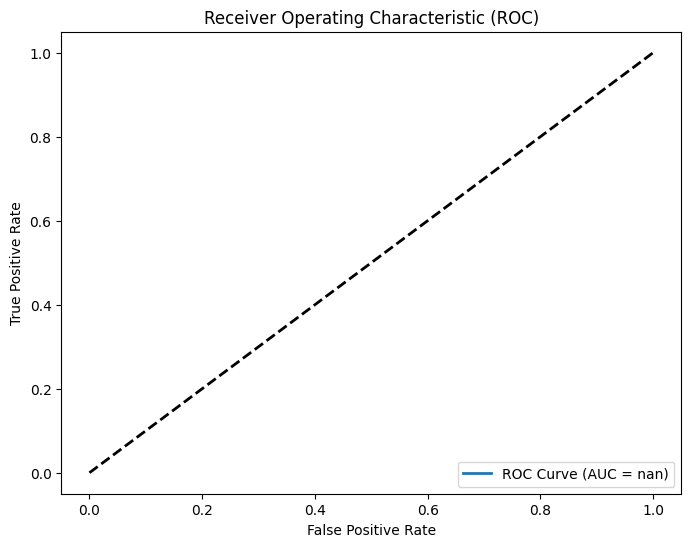

In [12]:
# Visualizing the ROC Curve
# ===============================
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

This cell plots the ROC curve, which is essential for evaluating classifier performance, especially on imbalanced datasets. The Area Under the Curve (AUC) provides an aggregate measure of performance across all classification thresholds.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
6582/6582 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Original Kernel SHAP values shape: (1, 29, 1)
Squeezed Kernel SHAP values shape: (1, 29)


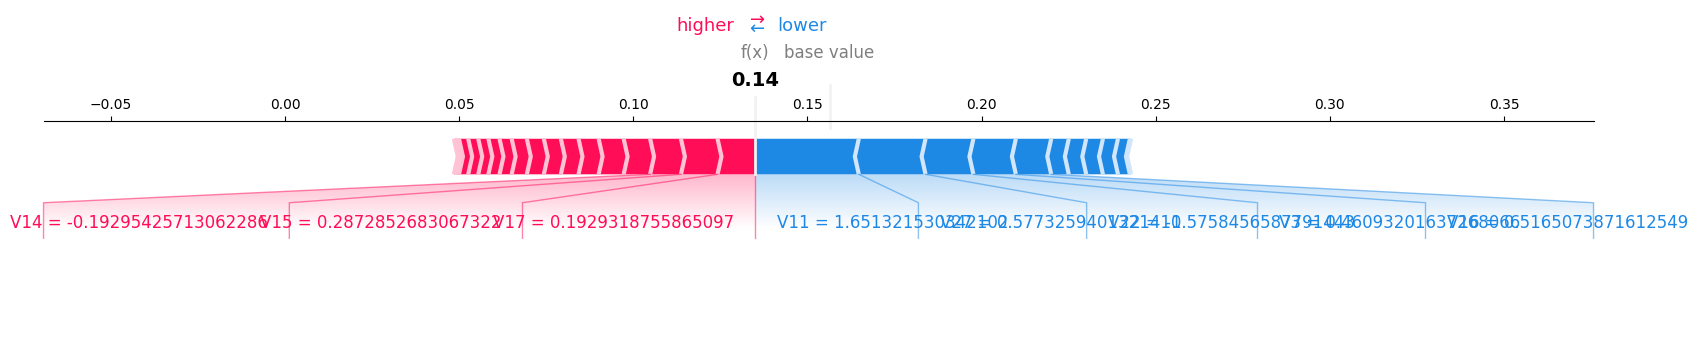

In [32]:
# Use a single sample for KernelExplainer
X_test_sample = X_test[:1]
X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Create a KernelExplainer using model.predict and the background data
explainer_kernel = shap.KernelExplainer(model.predict, background)

# Compute SHAP values for the selected sample
shap_values_kernel = explainer_kernel.shap_values(X_test_sample)
print("Original Kernel SHAP values shape:", np.array(shap_values_kernel).shape)

# Squeeze out the extra dimension (expected shape: (1, 29))
shap_values_kernel = np.squeeze(shap_values_kernel, axis=2)
print("Squeezed Kernel SHAP values shape:", np.array(shap_values_kernel).shape)

# Convert the single sample to a Series (1D array) for force_plot
single_sample = X_test_sample_df.iloc[0]

# Now create a force plot with the adjusted SHAP values and single sample
shap.force_plot(
    explainer_kernel.expected_value,
    shap_values_kernel[0],
    single_sample,
    matplotlib=True
)


Here, we use SHAP's DeepExplainer with a random subset of training data as a background reference. The force plot helps explain one individual prediction, while the summary plot gives a broader view of feature importance across multiple predictions.

In [22]:

#Simulated Real-Time Fraud Monitoring
# ===============================
import time

def simulate_real_time_monitoring(model, scaler, sample_data, n_iterations=3):
    """
    Simulate real-time fraud monitoring by predicting fraud probabilities for new transactions.
    This function simulates streaming data by randomly selecting a few samples at each iteration.
    """
    print("Starting simulated real-time fraud monitoring...\n")
    for i in range(n_iterations):
        # Simulate receiving 5 new transactions
        new_samples = sample_data[np.random.choice(sample_data.shape[0], 5, replace=False)]
        # Standardize new samples using the same scaler as before
        new_samples_scaled = scaler.transform(new_samples)
        # Predict fraud probabilities for these transactions
        predictions = model.predict(new_samples_scaled)
        print(f"Iteration {i+1}:")
        for j, prob in enumerate(predictions):
            label = "Fraudulent" if prob > 0.5 else "Legitimate"
            print(f"  Transaction {j+1}: Fraud Probability = {prob[0]:.4f} -> {label}")
        print("\n---\n")
        # Wait 2 seconds to simulate time delay in data streaming
        time.sleep(2)

# Use the original features (excluding 'Class' and 'Time') as sample data for simulation
sample_data = df.drop(['Class', 'Time'], axis=1).values
simulate_real_time_monitoring(model, scaler, sample_data, n_iterations=3)


Starting simulated real-time fraud monitoring...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Iteration 1:
  Transaction 1: Fraud Probability = 0.3821 -> Legitimate
  Transaction 2: Fraud Probability = 0.3159 -> Legitimate
  Transaction 3: Fraud Probability = 0.2655 -> Legitimate
  Transaction 4: Fraud Probability = 0.3025 -> Legitimate
  Transaction 5: Fraud Probability = 0.1840 -> Legitimate

---



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2:
  Transaction 1: Fraud Probability = 0.2842 -> Legitimate
  Transaction 2: Fraud Probability = 0.4128 -> Legitimate
  Transaction 3: Fraud Probability = 0.2938 -> Legitimate
  Transaction 4: Fraud Probability = 0.1852 -> Legitimate
  Transaction 5: Fraud Probability = 0.1646 -> Legitimate

---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3:
  Transaction 1: Fraud Probability = 0.2765 -> Legitimate
  Transaction 2: Fraud Probability = 0.2429 -> Legitimate
  Transaction 3: Fraud Probability = 0.2452 -> Legitimate
  Transaction 4: Fraud Probability = 0.3440 -> Legitimate
  Transaction 5: Fraud Probability = 0.3314 -> Legitimate

---



This function simulates a live environment by randomly sampling transactions and predicting their fraud probabilities. By looping through several iterations, you mimic real-time monitoring where new data continuously arrives.

In [23]:
# ===============================
# Model Saving for Deployment
# ===============================
# Save the trained model to a file for later deployment or further tuning.
model.save("fin_guard_fraud_detection_model.h5")
print("Model saved as 'fin_guard_fraud_detection_model.h5'")


Model saved as 'fin_guard_fraud_detection_model.h5'


Saving the model allows you to deploy it in production environments or use it in subsequent sessions without retraining.

In [24]:
# ===============================
# Autoencoder-Based Anomaly Detection
# ===============================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define dimensions for the autoencoder
input_dim = X_train.shape[1]
encoding_dim = 16  # You can experiment with different sizes

# Build the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the autoencoder on the training data
history_auto = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=2048,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Compute reconstruction error on the test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Define an anomaly threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
print("Autoencoder anomaly detection threshold (95th percentile):", threshold)

# Flag anomalies based on the reconstruction error
y_pred_auto = (mse > threshold).astype(int)

# Evaluate autoencoder performance using classification metrics
print("Classification Report for Autoencoder-Based Anomaly Detection:")
print(classification_report(y_test, y_pred_auto))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 29)                  │             493 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 973 (3.80 KB)

 Trainable params: 973 (3.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 - 1s - 1s/step - loss: 1.2878 - val_loss: 1.3196
Epoch 2/50
1/1 - 0s - 113ms/step - loss: 1.2853 - val_loss: 1.3171
Epoch 3/50
1/1 - 0s - 105ms/step - loss: 1.2827 - val_loss: 1.3147
Epoch 4/50
1/1 - 0s - 113ms/step - loss: 1.2802 - val_loss: 1.3122
Epoch 5/50
1/1 - 0s - 104ms/step - loss: 1.2777 - val_loss: 1.3098
Epoch 6/50
1/1 - 0s - 109ms/step - loss: 1.2752 - val_loss: 1.3074
Epoch 7/50
1/1 - 0s - 111ms/step - loss: 1.2726 - val_loss: 1.3049
Epoch 8/50
1/1 - 0s - 109ms/step - loss: 1.2701 - val_loss: 1.3025
Epoch 9/50
1/1 - 0s - 102ms/step - loss: 1.2676 - val_loss: 1.3001
Epoch 10/50
1/1 - 0s - 153ms/step - loss: 1.2651 - val_loss: 1.2978
Epoch 11/50
1/1 - 0s - 170ms/step - loss: 1.2625 - val_loss: 1.2954
Epoch 12/50
1/1 - 0s - 259ms/step - loss: 1.2600 - val_loss: 1.2930
Epoch 13/50
1/1 - 0s - 210ms/step - loss: 1.2576 - val_loss: 1.2907
Epoch 14/50
1/1 - 0s - 165ms/step - loss: 1.2551 - val_loss: 1.2883
Epoch 15/50
1/1 - 0s - 319ms/step - loss: 1.2527 - val_loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This block trains an autoencoder using only the training data. After training, it computes the reconstruction error for each test sample. A threshold (set at the 95th percentile of errors) is used to flag anomalies. The classification report shows how well this unsupervised approach detects fraud compared to ground truth labels.

In [25]:
# ===============================
# Ensemble Model
# ===============================
# Supervised model predictions (fraud probability)
y_pred_prob_supervised = model.predict(X_test)

# Normalize the autoencoder's reconstruction error to a [0, 1] range
mse_min, mse_max = mse.min(), mse.max()
mse_norm = (mse - mse_min) / (mse_max - mse_min)

# Ensemble: Compute a weighted average of the supervised prediction and normalized anomaly score
ensemble_score = 0.5 * y_pred_prob_supervised.flatten() + 0.5 * mse_norm
y_pred_ensemble = (ensemble_score > 0.5).astype(int)

print("Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       0.00      0.00      0.00         0

    accuracy                           0.99       200
   macro avg       0.50      0.50      0.50       200
weighted avg       1.00      0.99      1.00       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This ensemble approach computes a score that equally weighs the supervised model’s prediction and the autoencoder’s anomaly score. Transactions with a combined score above 0.5 are flagged as fraudulent. The ensemble may capture complementary information, potentially boosting overall detection performance.

In [26]:
# ===============================
# Simulated Real-Time Streaming with Apache Kafka
# ===============================
try:
    from kafka import KafkaConsumer
    import json
except ImportError:
    print("kafka-python package not installed. Please install it using '!pip install kafka-python'.")

def run_kafka_consumer():
    """
    Run a Kafka consumer that listens for transaction data, preprocesses the input,
    and predicts fraud using the trained model.
    Note: This code requires a running Kafka broker and the 'transactions_topic' to be set up.
    """
    try:
        # Initialize a Kafka consumer to listen to the 'transactions_topic'
        consumer = KafkaConsumer(
            'transactions_topic',
            bootstrap_servers=['localhost:9092'],
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            group_id='fraud_detection_group',
            value_deserializer=lambda x: json.loads(x.decode('utf-8'))
        )
        print("Kafka consumer started, listening to 'transactions_topic'...")

        # Continuously listen for new messages from Kafka
        for message in consumer:
            # Retrieve transaction features from the message payload
            transaction_data = message.value.get('transaction_features')
            if transaction_data is None:
                print("Received a message without 'transaction_features'. Skipping...")
                continue

            # Convert the received transaction data into the proper format
            new_transaction = np.array(transaction_data).reshape(1, -1)

            # Preprocess the new transaction using the previously fitted scaler
            new_transaction_scaled = scaler.transform(new_transaction)

            # Predict fraud probability using the trained model
            prediction = model.predict(new_transaction_scaled)
            fraud_prob = prediction[0][0]

            # Decide if the transaction is fraudulent based on a threshold of 0.5
            if fraud_prob > 0.5:
                print(f"Alert: Potential Fraud Detected! (Probability: {fraud_prob:.4f})")
            else:
                print(f"Transaction is legitimate. (Probability: {fraud_prob:.4f})")

    except Exception as e:
        print("Error in Kafka consumer:", e)

# Uncomment the following line to run the Kafka consumer in your production environment.
# run_kafka_consumer()

print("Simulated Kafka streaming code is provided as pseudo-code for production integration.")


kafka-python package not installed. Please install it using '!pip install kafka-python'.
Simulated Kafka streaming code is provided as pseudo-code for production integration.
